In [714]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline

In [1097]:
# Loading Movie sets:

ratings="https://github.com/qcrochard/Data/raw/master/Movies/ratings.csv"
movies="https://github.com/qcrochard/Data/raw/master/Movies/movies.csv"

df_ratings = pd.read_csv(ratings, sep=',')
df_ratings.columns = ['userId', 'itemId', 'rating', 'timestamp']
df_ratings = df_ratings.drop('timestamp', axis=1)

df_movies = pd.read_csv(movies, sep=',')
df_movies.columns = ['itemId', 'title', 'genres']

## Data Exploration:

In [716]:
print(df_movies.shape[0],"movies")
print(df_ratings.userId.nunique(),"users")
print(df_ratings.shape[0], "users ratings")
display(df_movies.head(), df_ratings.head())

9742 movies
610 users
100836 users ratings


,itemId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,itemId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


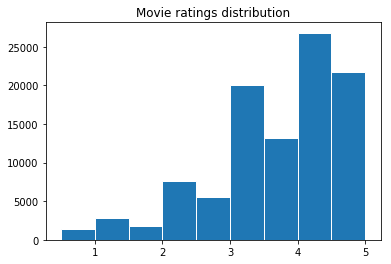

In [717]:
# Looking at ratings distribution:

plt.hist(df_ratings.rating, bins=9, edgecolor='white')
plt.title('Movie ratings distribution')
plt.show()

# No user have put a 0 to a movie.

In [1083]:
# Pivoting tables to get users vs ratings:

df_user_item = df_ratings.pivot(index = 'userId', columns ='itemId', values = 'rating')

# Sort index/rows (userId's) and columns (itemId's)
df_user_item.sort_index(axis=0, inplace=True)
df_user_item.sort_index(axis=1, inplace=True) 

perc_fill = 100*np.count_nonzero(~np.isnan(df_user_item))/df_user_item.size
print("df_user_item of shape {} is {}% empty".format(df_user_item.shape,np.round(100-perc_fill,2)))

df_user_item.iloc[:5,:10] # preview: many missing values

df_user_item of shape (610, 9724) is 98.3% empty


itemId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


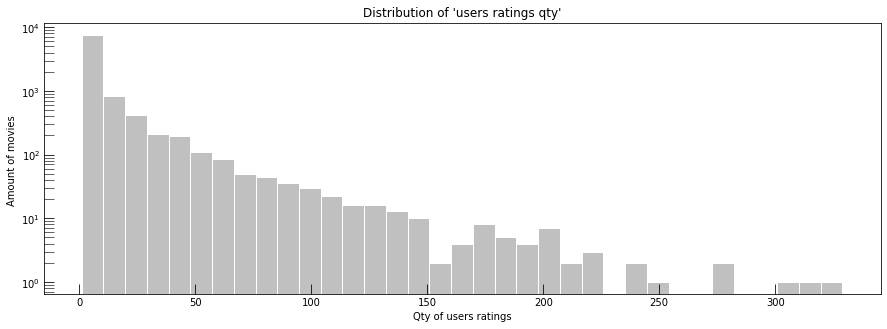

In [1084]:
# Ratings distribution:

plt.subplots(figsize=(15,5))
plt.hist(df_user_item.count(), bins=35, color='silver', edgecolor='white')
plt.tick_params(which='both', direction='in', length=10)
plt.yscale('log')
plt.ylabel('Amount of movies ')
plt.xlabel('Qty of users ratings')
plt.title("Distribution of 'users ratings qty'")
plt.show()

# 7000 movies have less than 10 ratings
# 3 movies have more than 300 ratings

## Recommendation:

Insprired from:
- https://www.youtube.com/watch?v=E8aMcwmqsTg
- http://nicolas-hug.com/blog/matrix_facto_3

How ?

$R$ Factorization: a product of factors $\hat{R} = P.Q^{T}$ <br/>
Where:
- $R$: the users_movies matrix: *(n users, p movies)*
- $P$ : *(n rows, k columns)*, no need to be orthogonal or unit vector
- $Q^{T}$ : *(k rows, p columns)*, no need to be orthogonal or unit vector

The matrices P and Q maps users & movies to a latent space (k dim). <br/>

The product $P.Q^{T}$ gives (the best approximation) of the ratings we already know. <br/>
So the missing entries can then be predicted using these 2 matrices P and Q. <br/>

We're searching for $Q$ and $P$ minimising the error:
$$\begin{equation}  \Sigma_{i,j} (r_{i,j}-\hat{r}_{i,j})^{2} = \Sigma_{i,j} (r_{i,j}-p_{i}.q^{T}_{j})^{2} \end{equation}$$ 
Where:<br/>
- $r_{i,j}$ is a cell of $R$: (line i, col j)
- $p_{i}$ is a line of $P$
- $q^{T}_{j}$ is a column of $Q^{T}$

Finding P, Q minimising error (maybe locally) by Gradient Descent: $p_{n+1} = p_{n}-\eta.\Delta p$
$$\begin{equation}   p_{i}←p_{i}+\eta.q_{j}(r_{ij}−p_{i}.q_{j})  \end{equation}$$
$$\begin{equation}   q_{j}←q_{j}+\eta.p_{i}(r_{ij}−p_{i}.q_{j})  \end{equation}$$

### Manually:

In [1085]:
R = df_user_item
n = df_ratings.userId.nunique() # No. of users
p = df_ratings.itemId.nunique() # No. of movies
df_ratings.head()

# each rating is a cell of df_ratings:
#   userId = i
#   itemId = j

,userId,itemId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [1086]:
# recreating Id: to ensure full sequence without holes in i,j

R = R.reset_index(drop=True)
R = (R.T.reset_index(drop=True)).T
R.index.name = 'userId'
R.columns.name = 'itemId'

old_new_itemId = {key:value for (key,value) in list(zip(df_user_item.columns, R.columns))}
old_new_userId = {key:value for (key,value) in list(zip(df_user_item.index, R.index))}

# R_tab = new df_ratings
R_tab = R.stack().reset_index()
R_tab.columns = ['userId','itemId','rating']

# M_tab = new df_movies
M_tab = df_movies[['itemId','title']]
M_tab = M_tab[M_tab['itemId'].isin(df_user_item.columns)] # keeping only movies from R
M_tab['itemId'] = M_tab['itemId'].apply(lambda x: old_new_itemId[x])

In [1087]:
def SGD(X, k=10, eta=0.01, epoch_no=3, max_iter=5):
    """ Input: dataframe containing: userId|itemId|rating per row
        Parameters: k = latent space size
                    eta = learning rate
                    epoch_no = No. of iterations
        Output: P, Q """

    # Initialisation:
    P = np.random.rand(n,k)    # P = np.random.normal(0,0.1,(n,k))
    Q = np.random.rand(k,p).T  # Q = np.random.normal(0,0.1,(k,p)).T

    # Iteration:
    while epoch_no>0 or max_iter>0:
        epoch_no -= 1
        max_iter -= 1
        
        # Loop over the data:
        for index in X.index:
            r_ij = X.loc[index,'rating']      # current cell in R
            i = int(X.loc[index,'userId'])    # current userId
            j = int(X.loc[index,'itemId'])    # current itemId
            P[i] += eta*(r_ij-P[i].dot(Q[j]))
            Q[j] += eta*(r_ij-P[i].dot(Q[j]))

    return P, Q

In [1088]:
# Calculating P and Q:
P, Q = SGD(R_tab,
           epoch_no=3,
           k=10,    # parameters to define by cross-validation
           eta=0.01
           ) 

# Recreating R (& R_tab) matrix from P and Q:
R_approx = P.dot(Q.T)
R_approx = pd.DataFrame(np.round(R_approx,1))

In [1089]:
# Applying rating limits:

print("R_predict (max,min)=({},{})".format(R_approx.max().max(), R_approx.min().min()))

for index, row in R_approx.iterrows():
    for col, cell in row.iteritems():
        if cell<0:
            R_approx.loc[index,col] = 0
        elif cell>5:
            R_approx.loc[index,col] = 5

R_predict (max,min)=(7.7,0.2)


In [1092]:
# Comparison R and R_approx example for userId 0:

display(R.loc[0,:].head(10))  # R header for i = 0
display(R_approx.loc[0,0:10]) # R_approx header for i = 0

itemId
0    4.0
1    NaN
2    4.0
3    NaN
4    NaN
5    4.0
6    NaN
7    NaN
8    NaN
9    NaN
Name: 0, dtype: float64

0     4.7
1     4.1
2     3.8
3     3.3
4     3.3
5     4.6
6     3.8
7     3.4
8     3.8
9     4.3
10    4.5
Name: 0, dtype: float64

Recommendation to a user:

In [1093]:
# 10 best movies initially rated by userId 0:

movies_list = list((R.loc[10]).sort_values(ascending=False)[:10].index)
display(M_tab[M_tab['itemId'].isin(movies_list)])

# 10 recommendations for userId 0:

movies_rated = R.loc[0].dropna().index
recommendations = list((R_approx.loc[10].drop(movies_rated)).sort_values(ascending=False)[:10].index)
display(M_tab[M_tab['itemId'].isin(recommendations)])

,itemId,title
97,97,Braveheart (1995)
123,123,Apollo 13 (1995)
307,307,Clear and Present Danger (1994)
314,314,Forrest Gump (1994)
398,398,"Fugitive, The (1993)"
463,463,Searching for Bobby Fischer (1993)
510,510,"Silence of the Lambs, The (1991)"
839,838,Top Gun (1986)
1187,1186,Contact (1997)
1503,1502,Saving Private Ryan (1998)


,itemId,title
1268,1267,"Wings of the Dove, The (1997)"
1427,1426,In the Heat of the Night (1967)
2675,2671,Up at the Villa (2000)
3672,3667,Little Dieter Needs to Fly (1997)
4165,4159,"Pianist, The (2002)"
4615,4607,Kill Bill: Vol. 1 (2003)
5202,5192,"Jetée, La (1962)"
6405,6388,Ratatouille (2007)
7413,7396,"Social Network, The (2010)"
8896,8878,Bitter Lake (2015)


Now we must optimise the algorithm:
- split data into train / test set to measure model error or use cross validation
- grid search SGD parameters: k, eta to determine best P and Q
- use regularization in case of overfit, and also determine best lambda

But we will actually use a better model based on this same factorisation, using Surprise library.

### Same principle using Surprise library:
See:
- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://www.youtube.com/watch?v=GGWBMg0i9d4

Using Simon Funk's Netflix model: $\hat{r}_{i,j} = \mu + b_{i} + b_{j} + p_{i}.q^{T}_{j} $
- "Global" estimation of the rating:
    - $\mu$ : mean rating of all movies
    - $b_{i}$ : mean rating for user $i$
    - $b_{j}$ : mean rating for movie $j$
- "Local" estimation of the rating:
    - ${r}_{i,j}$ : is a cell of $R$: (line i, col j)
    - $p_{i}$ : is a line of $P$
    - $q^{T}_{j}$ : is a column of $Q^{T}$ = a line of $Q$

Determining $P$, $Q$ by minimising (introducing regularization parameter $\lambda$ to prevent overfit): 
$$\begin{equation}  \Sigma_{i,j} (r_{i,j}-\hat{r}_{i,j})^{2} + \lambda.(\Sigma_{i}||p_{i}||^{2}+\Sigma_{j}||q_{j}||^{2}) \end{equation}$$ 

Calculation of model error: $$\begin{equation} RMSE=\sqrt{ \Sigma_{i,j}(r_{i,j}-\hat{r}_{i,j})^{2} }  \end{equation}$$ 
- Using cross-validation to calculate RMSE
- And choosing best parameters minimising RMSE:
    - $k$ latent space size
    - learning rate $\eta$
    - regularization term $\lambda$

In [1005]:
from surprise import SVD
from surprise import Reader

# Loading dataframe into Reader object
reader = Reader(rating_scale=(0, 5)) # Creating a Reader object: specifying rating scale
data = Dataset.load_from_df(df_ratings[['userId', 'itemId', 'rating']], reader)

# Using SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) # this function calls .fit()

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8646  0.8791  0.8740  0.8797  0.8718  0.8738  0.0055  
MAE (testset)     0.6671  0.6752  0.6724  0.6717  0.6696  0.6712  0.0027  
Fit time          4.49    4.44    4.38    4.35    4.46    4.42    0.05    
Test time         0.12    0.13    0.12    0.13    0.13    0.13    0.00    


{'test_rmse': array([0.86455893, 0.87911772, 0.87402865, 0.8796689 , 0.87177439]),
 'test_mae': array([0.66705372, 0.6752129 , 0.67236723, 0.6717199 , 0.6695582 ]),
 'fit_time': (4.488968133926392,
  4.442136764526367,
  4.376144647598267,
  4.350881338119507,
  4.459052801132202),
 'test_time': (0.12469673156738281,
  0.13109731674194336,
  0.1249701976776123,
  0.1326453685760498,
  0.12566447257995605)}

In [1006]:
# Tune algorithm with grid search: selecting best parameters:

from surprise.model_selection import GridSearchCV
param_grid = {'lr_all': [0.01,0.03], # learning_rate eta
              'reg_all': [0.3,0.4],  # regularization lambda
              'n_factors': [10,20],  # latent space dimension
              'n_epochs': [5],
              'random_state':[1]}

gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse'], cv=3)
gs.fit(data)  # must use whole dataset, as not enough values in trainset for cross validation

print(gs.best_score['rmse'])  # best RMSE score
print(gs.best_params['rmse']) # parameters that gave the best RMSE score

0.8824822553348262
{'lr_all': 0.03, 'reg_all': 0.3, 'n_factors': 10, 'n_epochs': 5, 'random_state': 1}


#### Final model:

In [1007]:
# Algorithm with best rmse:
algo = gs.best_estimator['rmse']

# Building train and test sets:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

# Fitting and predicting:
algo.fit(trainset)
predictions = algo.test(testset)

In [1098]:
# Example of user 1 initial ratings

df_ratings = df_ratings.join(df_movies.set_index('itemId')['title'], 
                             how='inner',
                             on='itemId').sort_values(['userId','itemId'])
df_ratings[['title','rating']].head()

,title,rating
0,Toy Story (1995),4.0
1,Grumpier Old Men (1995),4.0
2,Heat (1995),4.0
3,Seven (a.k.a. Se7en) (1995),5.0
4,"Usual Suspects, The (1995)",5.0


In [1019]:
# Same movies/user predicted ratings: 

for index, row in df_ratings.head(5).iterrows():
    i = row['userId']
    j = row['itemId']
    print(row['title']," : ", np.round(algo.predict(i,j)[3],1))

Toy Story (1995)  :  4.4
Grumpier Old Men (1995)  :  3.9
Heat (1995)  :  4.5
Seven (a.k.a. Se7en) (1995)  :  4.6
Usual Suspects, The (1995)  :  4.8


In [1008]:
# All predictions are in a list: preview

predictions[0:5]

[Prediction(uid=1, iid=318, r_ui=3.501556983616962, est=4.890763679292762, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.501556983616962, est=4.673021842379559, details={'was_impossible': False}),
 Prediction(uid=1, iid=6874, r_ui=3.501556983616962, est=4.69166115982576, details={'was_impossible': False}),
 Prediction(uid=1, iid=8798, r_ui=3.501556983616962, est=4.381814467744028, details={'was_impossible': False}),
 Prediction(uid=1, iid=46970, r_ui=3.501556983616962, est=4.128792421280579, details={'was_impossible': False})]

#### Top 5 recommendation:

    Reminder: object prediction was built from train_set

In [1039]:
len(predictions) # too long to extract the whole list content into dataframe and then filter
                 # needs to filter before the full conversion to dataframe

5830804

In [1068]:
# Using high performance container (defaultdict": to speed up operations) to extract values from predictions:

d = defaultdict(list) # key   =   userId
                      # value = [(itemId, R_ij_est), ..., ()]
for i, j, r_ij, r_ij_pred, _ in predictions:
    d[i].append((j, r_ij_pred))

print(len(d), len(d[1])) # 610 clefs: userId and 9492 lists containing all tuples (itemId, R_ij_est)

610 9492


In [1099]:
# Filtering top 5 best rated movies:

for i, L_item_rating in d.items():
    L_item_rating.sort(key=lambda x: x[1], reverse=True) # sorting movie ratings from best to worst rating for each user
    d[i] = d[i][:5]                                      # keeping best 5 movies

In [1100]:
# Extracting 5 best movies for each user:

df = pd.DataFrame(columns=['userId','itemId','rating']).set_index(['userId','itemId'])
for i, L_item_rating in d.items():
    for j, rating in L_item_rating: # now looping through 5 best movies (instead of all movies) to build dataframe
        df.loc[(i,j),'rating'] = rating

In [1101]:
df.reset_index().join(df_movies.set_index('itemId')['title'], 
                             how='inner',
                             on='itemId').sort_values(['userId','itemId'])

,userId,itemId,rating,title
4,1,318,4.89076,"Shawshank Redemption, The (1994)"
3,1,750,4.91099,Dr. Strangelove or: How I Learned to Stop Worr...
1,1,858,4.92259,"Godfather, The (1972)"
0,1,3451,4.97594,Guess Who's Coming to Dinner (1967)
2,1,177593,4.91462,"Three Billboards Outside Ebbing, Missouri (2017)"
7,2,750,4.30942,Dr. Strangelove or: How I Learned to Stop Worr...
6,2,858,4.32321,"Godfather, The (1972)"
9,2,2571,4.28443,"Matrix, The (1999)"
5,2,3451,4.37914,Guess Who's Coming to Dinner (1967)
8,2,177593,4.30873,"Three Billboards Outside Ebbing, Missouri (2017)"
